In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from functools import reduce

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from scipy.stats import ttest_ind

from utils import *

spark = get_spark_session()
sns.set(font_scale=2, style='white')

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [13]:
with open('config.json', 'r') as infile:
    config = json.load(infile)
indir = config['indir']
outdir = config['outdir']
admin_fname = config['admin_fname']
cantons_assignmenet_fname = config['cantons_assignment_fname']
rct_assignment_fname = config['rct_assignment_fname']
shapefile_fname = config['shapefile_fname']

### I. Plot unique MSISDN and IMEIs by day, remove outliers

In [247]:
toplevel_dir = outdir + 'january/'
months = ['2021-01']

cols = ['caller_msisdn', 'operator', 'month', 'day', 'imei']
voice = spark.read.csv(indir + 'voice/2021/1.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])
sms = spark.read.csv(indir + 'sms/2021/1.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])
cdr = voice.union(sms)

In [248]:
msisdn_by_day = cdr.groupby('day').agg(countDistinct('caller_msisdn'))\
    .withColumnRenamed('count(caller_msisdn)', 'count')
save_df(msisdn_by_day, toplevel_dir + 'msisdn_by_day.csv')

imei_by_day = cdr.groupby('day').agg(countDistinct('imei'))\
    .withColumnRenamed('count(imei)', 'count')
save_df(imei_by_day, toplevel_dir + 'imei_by_day.csv')

In [249]:
msisdn_by_day = pd.read_csv(toplevel_dir + 'msisdn_by_day.csv')
msisdn_by_day['day'] = pd.to_datetime(msisdn_by_day['day'])
msisdn_by_day = msisdn_by_day.sort_values('day', ascending=True)

imei_by_day = pd.read_csv(toplevel_dir + 'imei_by_day.csv')
imei_by_day['day'] = pd.to_datetime(imei_by_day['day'])
imei_by_day = imei_by_day.sort_values('day', ascending=True)

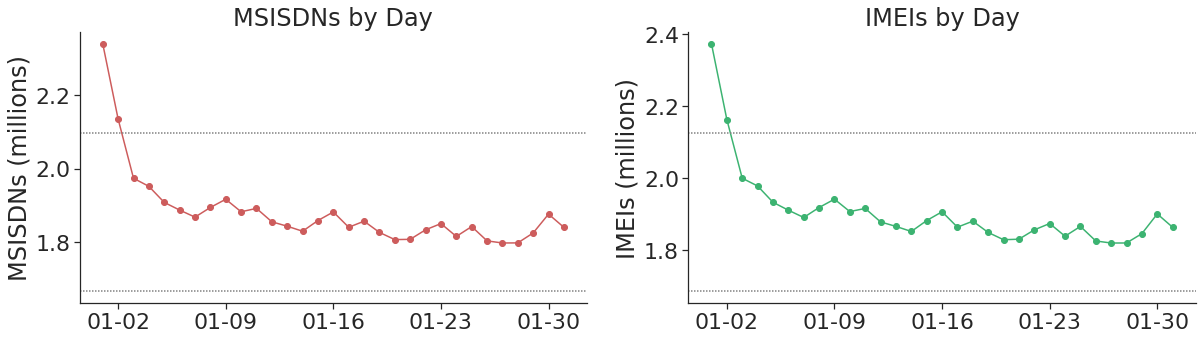

In [250]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(msisdn_by_day['day'], msisdn_by_day['count']/1000000, color='indianred')
ax[0].plot(msisdn_by_day['day'], msisdn_by_day['count']/1000000, color='indianred')
ax[0].set_title('MSISDNs by Day')
ax[0].set_ylabel('MSISDNs (millions)')
msisdn_sd_below = msisdn_by_day['count'].mean() - 2*msisdn_by_day['count'].std()
msisdn_sd_above = msisdn_by_day['count'].mean() + 2*msisdn_by_day['count'].std()
ax[0].axhline(msisdn_sd_above/1000000, color='grey', dashes=[1, 1])
ax[0].axhline(msisdn_sd_below/1000000, color='grey', dashes=[1, 1])

ax[1].scatter(imei_by_day['day'], imei_by_day['count']/1000000, color='mediumseagreen')
ax[1].plot(imei_by_day['day'], imei_by_day['count']/1000000, color='mediumseagreen')
ax[1].set_title('IMEIs by Day')
ax[1].set_ylabel('IMEIs (millions)')
imei_sd_below = imei_by_day['count'].mean() - 2*imei_by_day['count'].std()
imei_sd_above = imei_by_day['count'].mean() + 2*imei_by_day['count'].std()
ax[1].axhline(imei_sd_below/1000000, color='grey', dashes=[1, 1])
ax[1].axhline(imei_sd_above/1000000, color='grey', dashes=[1, 1])

locator = mdates.DayLocator(interval=7)
formatter = mdates.DateFormatter('%m-%d')
for a in range(len(ax)):
    ax[a].xaxis.set_major_locator(locator)
    ax[a].xaxis.set_major_formatter(formatter)
    simpleaxis(ax[a])

plt.show()

outliers_msisdn = list(msisdn_by_day[(msisdn_by_day['count'] < msisdn_sd_below) | \
                                     (msisdn_by_day['count'] > msisdn_sd_above)]['day'])
outliers_imei = list(msisdn_by_day[(msisdn_by_day['count'] < msisdn_sd_below) | \
                                   (msisdn_by_day['count'] > msisdn_sd_above)]['day'])
outliers = list(set([x.strftime('%Y-%m-%d') for x in outliers_msisdn + outliers_imei]))
pd.DataFrame(outliers, columns=['outliers']).to_csv(toplevel_dir + 'outliers.csv', index=False)

In [251]:
cdr = cdr.where(~col('day').isin(outliers))

imei_per_msisdn = cdr.groupby('caller_msisdn').agg(countDistinct('imei'))\
    .withColumnRenamed('count(imei)', 'count')
save_df(imei_per_msisdn, toplevel_dir + 'imei_per_msisdn.csv')

msisdn_per_imei = cdr.groupby('imei').agg(countDistinct('caller_msisdn'))\
    .withColumnRenamed('count(caller_msisdn)', 'count')
save_df(msisdn_per_imei, toplevel_dir + 'msisdn_per_imei.csv')

count_txns_msisdn = cdr.groupby('caller_msisdn').agg(count('imei'))\
    .withColumnRenamed('count(imei)', 'count')
save_df(count_txns_msisdn, toplevel_dir + 'count_transactions_msisdn.csv')

count_txns_imei = cdr.groupby('imei').agg(count('caller_msisdn'))\
    .withColumnRenamed('count(caller_msisdn)', 'count')
save_df(count_txns_imei, toplevel_dir + 'count_transactions_imei.csv')

### II. Generate datasets of IMEI/MSISD and MSISDN/IMEI

In [3]:
toplevel_dir = outdir + 'january'
months = ['2021-01']

outliers = list(pd.read_csv(toplevel_dir + 'outliers.csv')['outliers'])
cols = ['caller_msisdn', 'operator', 'month', 'day', 'imei', 'recipient_msisdn']
voice = spark.read.csv(indir + 'voice/2020/11.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])\
    .where(~(col('day').isin(outliers)))
sms = spark.read.csv(indir + 'sms/2020/11.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])\
    .where(~(col('day').isin(outliers)))
cdr = voice.union(sms)

In [169]:
imei_per_msisdn = cdr.groupby('caller_msisdn').agg(count('imei'))
msisdn_per_imei = cdr.groupby('imei').agg(count('caller_msisdn'))
save_df(imei_per_msisdn, toplevel_dir + '/imei_per_msisdn.csv')
save_df(msisdn_per_imei, toplevel_dir + '/msisdn_per_imei.csv')

### Define treatment at IMEI level

In [111]:
cols = ['caller_msisdn', 'day', 'imei', 'recipient_msisdn', 'interaction']

voice_oct = spark.read.csv(indir + 'voice/2020/10.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])
sms_oct = spark.read.csv(indir + 'sms/2020/10.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])
           
voice_nov = spark.read.csv(indir + 'voice/2020/11.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])
sms_nov = spark.read.csv(indir + 'sms/2020/11.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])

voice_dec = spark.read.csv(indir + 'voice/2020/12.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])
sms_dec = spark.read.csv(indir + 'cdr/sms/2020/12.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])

voice_jan = spark.read.csv(indir + 'voice/2021/1.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])
sms_jan = spark.read.csv(indir + 'sms/2021/1.csv', header=True)\
    .select(cols)\
    .na.drop(subset=['caller_msisdn', 'day', 'imei'])

cdr = reduce(DataFrame.unionAll, [voice_nov, sms_nov, voice_dec, sms_dec])

In [284]:
novissi = pd.read_csv('/data/togo_anon/novissi/gd/registrations/2021-05-19.csv')\
    [['Gender', 'Age', 'Prefecture', 'Canton', 'RegistrationDate', 'PhoneNumber']]
novissi['RegistrationDate'] = pd.to_datetime(novissi['RegistrationDate'])
novissi = novissi[novissi['RegistrationDate'] <= pd.to_datetime('2020-12-31')]
novissi['rural'] = novissi['Prefecture'].apply(lambda x: 0 if x in ['GOLFE', 'AGOE-NYIVE', 'TCHAOUDJO'] else 1)

# Check registered November-December
novissi['registered_nov_dec'] = ((novissi['RegistrationDate'] >= pd.to_datetime('2020-11-01')) & \
                                 (novissi['RegistrationDate'] <= pd.to_datetime('2020-12-31')))\
                                .astype('int')
novissi['registered_nov'] = ((novissi['RegistrationDate'] >= pd.to_datetime('2020-11-01')) & \
                             (novissi['RegistrationDate'] <= pd.to_datetime('2020-11-30')))\
.astype('int')
print('Percent between November and December: %.2f' % (100*(novissi['registered_nov_dec'].mean())))

# Check in targeted canton
targeted_cantons = pd.read_csv(cantons_assignment_fname)\
    .rename({'novissi_prefecture_name':'Prefecture', 'novissi_canton_name':'Canton', 
             'targeted':'targeted_canton'}, axis=1)\
    [['targeted_canton', 'Prefecture', 'Canton']]
novissi = novissi.merge(targeted_cantons, on=['Prefecture', 'Canton'], how='left')
novissi['targeted_canton'] = novissi['targeted_canton'].fillna(0)
print('Percent in targeted cantons: %.2f' % (100*(novissi[novissi['registered_nov_dec'] == 1]['targeted_canton']\
                                                  .mean())))

# Check below wealth threshold
wealth_scores = pd.read_csv(rct_assignment_fname)\
    .rename({'phone_number':'PhoneNumber', 'cdr_pmt':'poverty', 'treatment':'treated'}, axis=1)\
    [['PhoneNumber', 'poverty', 'treated']]
novissi = novissi.merge(wealth_scores, on='PhoneNumber', how='left')
novissi['below_wealth_threshold'] = (novissi['treated'] >= 0).astype('int')
print('Percent below wealth threshold: %.2f' % (100*(novissi[(novissi['registered_nov_dec'] == 1) & 
                                                             (novissi['targeted_canton'] == 1)]\
                                                     ['below_wealth_threshold'].mean())))
print('Percent treated: %.2f' % (100*(novissi[(novissi['registered_nov_dec'] == 1) & 
                                              (novissi['targeted_canton'] == 1) & 
                                              (novissi['below_wealth_threshold'] == 1)]\
                                                     ['treated'].mean())))

Percent between November and December: 97.97
Percent in targeted cantons: 87.42
Percent below wealth threshold: 32.73
Percent treated: 56.38


In [285]:
admin = spark.createDataFrame(novissi)

In [203]:
min_time = cdr.withColumn('day', to_timestamp(col('day')))\
    .withColumnRenamed('caller_msisdn', 'PhoneNumber')\
    .join(admin, on=['PhoneNumber'])\
    .withColumn('timedif', abs(datediff(col('day'), col('RegistrationDate'))))\
    .withColumn('min_timedif', min('timedif').over(Window.partitionBy('PhoneNumber')))\
    .where(col('timedif') == col('min_timedif'))

max_count = min_time.groupby(['PhoneNumber', 'imei']).agg(count('timedif'), first('timedif'))\
    .withColumnRenamed('count(timedif)', 'count_txns_on_day')\
    .withColumnRenamed('first(timedif)', 'days_to_txn')\
    .withColumn('max_txns', max('count_txns_on_day').over(Window.partitionBy('PhoneNumber')))\
    .where(col('count_txns_on_day') == col('max_txns'))

random_choice = max_count.withColumn('rand', rand())\
    .withColumn('max_random', max('rand').over(Window.partitionBy('PhoneNumber')))\
    .where(col('rand') == col('max_random'))

In [205]:
more_than_one_min_imei = min_time.groupby('PhoneNumber').agg(countDistinct('imei'))\
    .where(col('count(imei)') > 1)\
    .count()

print('Share of phone numbers with more than one IMEI on minimum day: %.2f' % 
     (100*more_than_one_min_imei/min_time.select('PhoneNumber').distinct().count()))

Share of phone numbers with more than one IMEI on minimum day: 5.50


In [206]:
more_than_one_max_count = max_count.groupby('PhoneNumber').agg(countDistinct('imei'))\
    .where(col('count(imei)') > 1)\
    .count()

print('Share of phone numbers with more than one IMEI with the max count on the minimum day: %.2f' % 
     (100*more_than_one_max_count/max_count.select('PhoneNumber').distinct().count()))

Share of phone numbers with more than one IMEI with the max count on the minimum day: 1.57


In [207]:
save_df(random_choice, outdir + 'imei_assignments.csv')

In [73]:
imeis = pd.read_csv(outdir + 'imei_assignments.csv')
print('Share of transactions within 1 day of registration: %.2f' % 
     (100*len(imeis[imeis['hours_to_txn'] <= 1])/len(imeis)) + '%')
print('Share of transactions within 7 days of registration: %.2f' % 
     (100*len(imeis[imeis['hours_to_txn'] <= 7])/len(imeis)) + '%')
print('Share of transactions within 30 days of registration: %.2f' % 
     (100*len(imeis[imeis['hours_to_txn'] <= 30])/len(imeis)) + '%')
grouped = imeis.groupby('imei').agg('count')
print('Share of IMEIs linked to more than one MSISDN: %.2f' % 
     (100*len(grouped[grouped['PhoneNumber'] > 1])/len(grouped)))

Share of transactions within 1 day of registration: 56.02%
Share of transactions within 7 days of registration: 83.49%
Share of transactions within 30 days of registration: 97.40%
Share of IMEIs linked to more than one MSISDN: 3.34


In [85]:
print('IMEI-centric dataset: %i' % len(imeis))
imeis_deduplicate = imeis.drop_duplicates(subset=['imei'])
imeis_deduplicate.to_csv(outdir + 'imei_assignments_deduplicated.csv',
                        index=False)
print('IMEI-centric dataset, deduplicated: %i' % len(imeis_no_duplicates))
counts = imeis.groupby('imei', as_index=False).agg('count')[['imei', 'PhoneNumber']]
no_duplicates = set(counts[counts['PhoneNumber'] == 1]['imei'])
imeis_drop_duplicates = imeis[imeis['imei'].isin(no_duplicates)]
imeis_drop_duplicates.to_csv(outdir + 'imei_assignments_drop_duplicates.csv',
                        index=False)
print('IMEI-centric dataset, no duplicates: %i' % len(imeis_drop_duplicates))

IMEI-centric dataset: 162560
IMEI-centric dataset, deduplicated: 156449
IMEI-centric dataset, no duplicates: 151231


### III. Table 2 Panel A: Entire Network

In [307]:
toplevel_dir = outdir + 'october/'

imei_per_msisdn = pd.read_csv(toplevel_dir + 'imei_per_msisdn.csv')
msisdn_per_imei = pd.read_csv(toplevel_dir + 'msisdn_per_imei.csv')
outcomes = [('imei_per_msisdn', imei_per_msisdn), 
            ('msisdn_per_imei', msisdn_per_imei)]

In [308]:
table = []
for label, outcome in outcomes:
    column = ['%.2f (%.2f)' % (outcome['count'].mean(), outcome['count'].std()), 
              '%.2f'% outcome['count'].median(), 
              '%.2f' % outcome['count'].mode()[0], 
              '%.2f' % (100*(outcome['count'] > 1).mean()),
              '%i' % len(outcome)]
    table.append(column)

table = pd.DataFrame(table).T
table.columns = [label for label, _ in outcomes]
table.index = ['Mean', 'Median', 'Mode', 'Share', 'N']
table

,imei_per_msisdn,msisdn_per_imei
Mean,1.35 (0.85),1.09 (1.95)
Median,1.00,1.00
Mode,1.00,1.00
Share,22.38,7.44
N,4508881,5600581


### IV. Match to administrative data

In [309]:
novissi = pd.read_csv(admin_fname)[['Gender', 'Age', 'Prefecture', 'Canton', 'RegistrationDate', 'PhoneNumber']]
novissi['RegistrationDate'] = pd.to_datetime(novissi['RegistrationDate'])
novissi = novissi[novissi['RegistrationDate'] <= pd.to_datetime('2020-12-31')]
novissi['rural'] = novissi['Prefecture'].apply(lambda x: 0 if x in 
                                               ['LOME COMMUNE', 'GOLFE', 'AGOE-NYIVE', 'TCHAOUDJO'] else 1)

# Check registered November-December
novissi['registered_nov_dec'] = ((novissi['RegistrationDate'] >= pd.to_datetime('2020-11-01')) & \
                                 (novissi['RegistrationDate'] <= pd.to_datetime('2020-12-31')))\
                                .astype('int')
novissi['registered_nov'] = ((novissi['RegistrationDate'] >= pd.to_datetime('2020-11-01')) & \
                             (novissi['RegistrationDate'] <= pd.to_datetime('2020-11-30')))\
.astype('int')
print('Percent between November and December: %.2f' % (100*(novissi['registered_nov_dec'].mean())))

# Check in targeted canton
targeted_cantons = pd.read_csv(canton_assignment_fname)\
    .rename({'novissi_prefecture_name':'Prefecture', 'novissi_canton_name':'Canton', 
             'targeted':'targeted_canton'}, axis=1)\
    [['targeted_canton', 'Prefecture', 'Canton']]
novissi = novissi.merge(targeted_cantons, on=['Prefecture', 'Canton'], how='left')
novissi['targeted_canton'] = novissi['targeted_canton'].fillna(0)
print('Percent in targeted cantons: %.2f' % (100*(novissi[novissi['registered_nov_dec'] == 1]['targeted_canton']\
                                                  .mean())))

# Check below wealth threshold
wealth_scores = pd.read_csv(rct_assignment_fname)\
    .rename({'phone_number':'PhoneNumber', 'cdr_pmt':'poverty', 'treatment':'treated'}, axis=1)\
    [['PhoneNumber', 'poverty', 'treated']]
novissi = novissi.merge(wealth_scores, on='PhoneNumber', how='left')
novissi['below_wealth_threshold'] = (novissi['treated'] >= 0).astype('int')
print('Percent below wealth threshold: %.2f' % (100*(novissi[(novissi['registered_nov_dec'] == 1) & 
                                                             (novissi['targeted_canton'] == 1)]\
                                                     ['below_wealth_threshold'].mean())))
print('Percent treated: %.2f' % (100*(novissi[(novissi['registered_nov_dec'] == 1) & 
                                              (novissi['targeted_canton'] == 1) & 
                                              (novissi['below_wealth_threshold'] == 1)]\
                                                     ['treated'].mean())))

# Link to IMEI
imeis = pd.read_csv(outdir + 'imei_assignments.csv')\
    [['PhoneNumber', 'imei']]
novissi = novissi.merge(imeis, on='PhoneNumber', how='left')
print('Percent of records linked to IMEI: %.2f' % (100 - 100*novissi['imei'].isnull().mean()))

Percent between November and December: 97.97
Percent in targeted cantons: 87.42
Percent below wealth threshold: 32.73
Percent treated: 56.38
Percent of records linked to IMEI: 92.85


### Table 1 Panel A and Table 2 Panel B: Matched to Admin Data

In [310]:
df = novissi[novissi['registered_nov_dec'] == 1].copy()

imei_per_msisdn = pd.read_csv(toplevel_dir + 'imei_per_msisdn.csv')\
    .rename({'caller_msisdn':'PhoneNumber', 'count':'imei_per_msisdn'}, axis=1)
msisdn_per_imei = pd.read_csv(toplevel_dir + 'msisdn_per_imei.csv')\
    .rename({'count':'msisdn_per_imei'}, axis=1)
counts_msisdn = pd.read_csv(toplevel_dir + 'count_transactions_msisdn.csv')\
    .rename({'caller_msisdn':'PhoneNumber', 'count':'msisdn_count_txns'}, axis=1)
counts_imei = pd.read_csv(toplevel_dir + 'count_transactions_imei.csv')\
    .rename({ 'count':'imei_count_txns'}, axis=1)
                                                                                                                           
df = df.merge(imei_per_msisdn, on='PhoneNumber', how='left')\
    .merge(msisdn_per_imei, on='imei', how='left')\
    .merge(counts_msisdn, on='PhoneNumber', how='left')\
    .merge(counts_imei, on='imei', how='left')

print('Percent with MSISDN data: %.2f' % (100 - 100*df['imei_per_msisdn'].isnull().mean()))
print('Percent with IMEI data: %.2f' % (100 - 100*df['msisdn_per_imei'].isnull().mean()))

Percent with MSISDN data: 71.22
Percent with IMEI data: 61.48


In [311]:
table = []
for outcome in ['imei_per_msisdn', 'msisdn_per_imei']:
    df_outcome = df.dropna(subset=[outcome])
    column = ['%.2f (%.2f)' % (df_outcome[outcome].mean(), df_outcome[outcome].std()), 
              '%.2f'% df_outcome[outcome].median(), 
              '%.2f' % df_outcome[outcome].mode()[0], 
              '%.2f' % (100*(df_outcome[outcome] > 1).mean()),
              '%i' % len(df_outcome)]
    table.append(column)

table = pd.DataFrame(table).T
table.columns = ['IMEI per MSISDN', 'MSISDN per IMEI']
table.index = ['Mean', 'Median', 'Mode', 'Share', 'N']
table

,IMEI per MSISDN,MSISDN per IMEI
Mean,1.60 (1.15),4.24 (63.19)
Median,1.00,1.00
Mode,1.00,1.00
Share,33.12,12.00
N,122185,105461


In [312]:
table = []
df_outcome = df.copy()

df_outcome['Age: 18-30'] = df_outcome['Age'].apply(lambda x: x <= 30).astype('int')
df_outcome['Age: 30-40'] = df_outcome['Age'].apply(lambda x: x > 30 and x <= 40).astype('int')
df_outcome['Age: 40-50'] = df_outcome['Age'].apply(lambda x: x > 40 and x <=50).astype('int')
df_outcome['Age: 50+'] = df_outcome['Age'].apply(lambda x: x > 50).astype('int')

column = ['%i' % (len(df_outcome[df_outcome['Gender'] == 'F'])), 
          '%i' % (len(df_outcome[df_outcome['Gender'] == 'M'])),
         '%i' % (len(df_outcome[df_outcome['Age: 18-30'] == 1])),
         '%i' % (len(df_outcome[df_outcome['Age: 30-40'] == 1])),
         '%i' % (len(df_outcome[df_outcome['Age: 40-50'] == 1])),
         '%i' % (len(df_outcome[df_outcome['Age: 50+'] == 1])),
         '%i' % (len(df_outcome[df_outcome['rural'] == 1])),
         '%i' % (len(df_outcome[df_outcome['rural'] == 0]))]
table.append(column)

column = ['%.2f' % (100*len(df_outcome[df_outcome['Gender'] == 'F'])/len(df_outcome)) + '%', 
          '%.2f' % (100*len(df_outcome[df_outcome['Gender'] == 'M'])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 18-30'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 30-40'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 40-50'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 50+'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['rural'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['rural'] == 0])/len(df_outcome)) + '%']
table.append(column)

table = pd.DataFrame(table).T
table.columns = ['N', '%']
table.index = ['Female', 'Male', '18-30', '30-40', '40-50', '50+', 'Rural', 'Urban']
print('N=%i' % len(df_outcome))
table

N=171548


,N,%
Female,95402,55.61%
Male,76146,44.39%
18-30,67423,39.30%
30-40,43612,25.42%
40-50,29418,17.15%
50+,31095,18.13%
Rural,167454,97.61%
Urban,4094,2.39%


### Table 1 Panel B and Table 2 Panel C: Enrolled in RCT

In [313]:
table = []
df_rct = df[(df['registered_nov_dec'] == 1) & (df['targeted_canton'] == 1) & 
            (df['below_wealth_threshold'] == 1)].copy()
for outcome in ['imei_per_msisdn', 'msisdn_per_imei']:
    df_outcome = df_rct.dropna(subset=[outcome])
    column = ['%.2f (%.2f)' % (df_outcome[outcome].mean(), df_outcome[outcome].std()), 
              '%.2f'% df_outcome[outcome].median(), 
              '%.2f' % df_outcome[outcome].mode()[0], 
              '%.2f' % (100*(df_outcome[outcome] > 1).mean()),
              '%i' % len(df_outcome)]
    table.append(column)

table = pd.DataFrame(table).T
table.columns = ['IMEI per MSISDN', 'MSISDN per IMEI']
table.index = ['Mean', 'Median', 'Mode', 'Share', 'N']
table

,IMEI per MSISDN,MSISDN per IMEI
Mean,1.50 (1.00),3.92 (60.87)
Median,1.00,1.00
Mode,1.00,1.00
Share,29.58,9.57
N,41741,35503


In [314]:
table = []

df_outcome = df_rct.copy()

df_outcome['Age: 18-30'] = df_outcome['Age'].apply(lambda x: x <= 30).astype('int')
df_outcome['Age: 30-40'] = df_outcome['Age'].apply(lambda x: x > 30 and x <= 40).astype('int')
df_outcome['Age: 40-50'] = df_outcome['Age'].apply(lambda x: x > 40 and x <=50).astype('int')
df_outcome['Age: 50+'] = df_outcome['Age'].apply(lambda x: x > 50).astype('int')

column = ['%i' % (len(df_outcome[df_outcome['Gender'] == 'F'])), 
          '%i' % (len(df_outcome[df_outcome['Gender'] == 'M'])),
         '%i' % (len(df_outcome[df_outcome['Age: 18-30'] == 1])),
         '%i' % (len(df_outcome[df_outcome['Age: 30-40'] == 1])),
         '%i' % (len(df_outcome[df_outcome['Age: 40-50'] == 1])),
         '%i' % (len(df_outcome[df_outcome['Age: 50+'] == 1])),
         '%i' % (len(df_outcome[df_outcome['rural'] == 1])),
         '%i' % (len(df_outcome[df_outcome['rural'] == 0]))]
table.append(column)

column = ['%.2f' % (100*len(df_outcome[df_outcome['Gender'] == 'F'])/len(df_outcome)) + '%', 
          '%.2f' % (100*len(df_outcome[df_outcome['Gender'] == 'M'])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 18-30'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 30-40'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 40-50'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['Age: 50+'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['rural'] == 1])/len(df_outcome)) + '%',
         '%.2f' % (100*len(df_outcome[df_outcome['rural'] == 0])/len(df_outcome)) + '%']
table.append(column)
table = pd.DataFrame(table).T
table.columns = ['N', '%']
table.index = ['Female', 'Male', '18-30', '30-40', '40-50', '50+', 'Rural', 'Urban']
print(len(df_outcome))
table

49086


,N,%
Female,24694,50.31%
Male,24392,49.69%
18-30,16084,32.77%
30-40,14770,30.09%
40-50,9428,19.21%
50+,8804,17.94%
Rural,49086,100.00%
Urban,0,0.00%


### Appendix Table: Baseline Tests for Balance

In [282]:
table = []
df_balance = df_rct.copy()
df_balance['female'] = df_balance['Gender'].apply(lambda x: 1 if x == 'F' else 0)
df_balance['shared_msisdn'] = df_balance['imei_per_msisdn']\
    .apply(lambda x: 1 if x > 1 else 0 if x == 1 else np.nan)
df_balance['shared_imei'] = df_balance['msisdn_per_imei']\
    .apply(lambda x: 1 if x > 1 else 0 if x == 1 else np.nan)

treatment = df_balance[df_balance['treated'] == 1]
control = df_balance[df_balance['treated'] == 0]

for var in ['female', 'Age', 'shared_msisdn', 'shared_imei', 'msisdn_count_txns']:
    ttest = ttest_ind(treatment[var].dropna(), control[var].dropna()).pvalue 
    stars = '***' if ttest < 0.001 else '**' if ttest < 0.01 else '*' if ttest < 0.05 else ''
    row = ['%.2f (%.2f)' % (treatment[var].mean(), treatment[var].std()), 
          '%.2f (%.2f)' % (control[var].mean(), control[var].std()),
          '%.2f' % (treatment[var].mean() - control[var].mean()) + stars]
    table.append(row)
    
table.append([len(treatment), len(control), len(df_balance)])
table = pd.DataFrame(table)
table.columns = ['Treatment', 'Control', 'Difference']
table.index = ['% Women', 'Age', 'Shared SIM', 'Shared Device', 'Number of Transactions', 'N']
table

,Treatment,Control,Difference
% Women,0.50 (0.50),0.51 (0.50),-0.00
Age,38.01 (13.49),37.91 (13.53),0.10
Shared SIM,0.29 (0.46),0.30 (0.46),-0.01
Shared Device,0.09 (0.29),0.10 (0.30),-0.00
Number of Transactions,45.47 (70.02),45.96 (71.37),-0.49
N,27673,21413,49086


### Figure 1: Geographic Heterogeneity

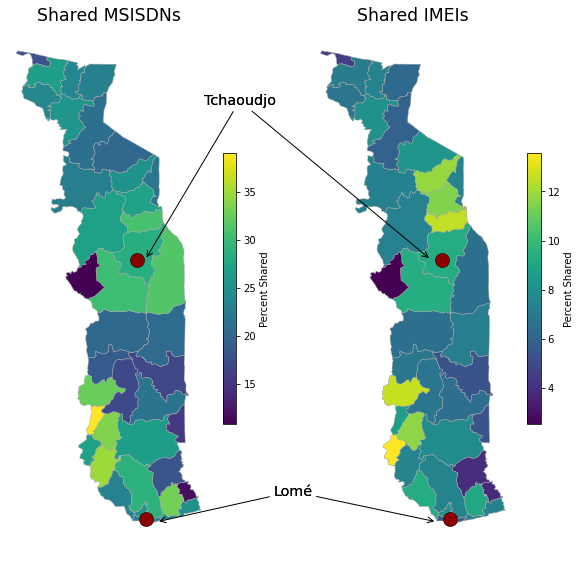

In [378]:
data = df.copy()

data['imei_per_msisdn'] = 100*(data['imei_per_msisdn'] > 1).astype('int')
data['msisdn_per_imei'] = 100*(data['msisdn_per_imei'] > 1).astype('int')

pop = data.groupby('Prefecture', as_index=False).agg('count')[['Prefecture', 'Gender']]\
    .rename({'Gender':'count'}, axis=1)
pop = pop[pop['count'] > 10]
avg = data.groupby('Prefecture', as_index=False).agg('mean')
avg = pop.merge(avg, on='Prefecture')
shapefile = gpd.read_file(shapefile_fname)[['PREFECTURE', 'geometry']]\
    .rename({'PREFECTURE':'Prefecture'}, axis=1)
shapefile['Prefecture'] = shapefile['Prefecture']\
    .apply(lambda x: 'KPENDJAL OUEST' if x == 'KPENDJAL-OUEST' else 
          'GOLFE' if x == 'LOME COMMUNE' else
          'OTI SUD' if x == 'OTI-SUD' else
          'MO' if x == 'PLAINE DU MO' else x)
avg = shapefile.merge(avg, on='Prefecture', how='inner')

sns.reset_orig()
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1%}'.format(x)
#cbar = plt.colorbar(format=FuncFormatter(fmt))
avg.plot(ax=ax[0], column=['imei_per_msisdn'], legend=True, 
         legend_kwds={'label': 'Percent Shared', 'shrink':0.5}, edgecolor='darkgrey', linewidth=0.5)

shapefile.plot(ax=ax[1], color='lightgrey')
avg.plot(ax=ax[1], column=['msisdn_per_imei'], legend=True,
        legend_kwds={'label': 'Percent Shared', 'shrink':0.5}, edgecolor='darkgrey', linewidth=0.5)

cities = pd.DataFrame([[6.19, 1.2254], [8.9228, 1.1353]])
cities.columns = ['longitude', 'latitude']
cities = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities['latitude'], cities['longitude']))
cities.plot(ax=ax[0], color='darkred', markersize=200, linewidth=0.5, edgecolor='black')
cities.plot(ax=ax[1], color='darkred', markersize=200, linewidth=0.5, edgecolor='black')

ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Shared MSISDNs', fontsize='xx-large')
ax[1].set_title('Shared IMEIs', fontsize='xx-large')

ax[0].annotate('Lomé', xy=[.27, .105], xytext=[.47, .15], xycoords='figure fraction', 
               textcoords='figure fraction', arrowprops={'arrowstyle':'->'}, fontsize='x-large')
ax[1].annotate('Lomé', xy=[.75, .105], xytext=[.47, .15], xycoords='figure fraction', 
               textcoords='figure fraction', arrowprops={'arrowstyle':'->'}, fontsize='x-large')
ax[0].annotate('Tchaoudjo', xy=[.25, .555], xytext=[.35, .82], xycoords='figure fraction', 
               textcoords='figure fraction', arrowprops={'arrowstyle':'->'}, fontsize='x-large')
ax[1].annotate('Tchaoudjo', xy=[.74, .555], xytext=[.35, .82], xycoords='figure fraction', 
               textcoords='figure fraction', arrowprops={'arrowstyle':'->'}, fontsize='x-large')
plt.savefig(outdir + 'maps.png', dpi=600, bbox_inches='tight')
plt.show()

### Table 3: Heterogeneity

In [217]:
data = df.copy()
data = data[data['registered_nov_dec'] == 1]
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'F' else 0)
data['Age: 18-30'] = data['Age'].apply(lambda x: x <= 30).astype('int')
data['Age: 30-40'] = data['Age'].apply(lambda x: x > 30 and x <= 40).astype('int')
data['Age: 40-50'] = data['Age'].apply(lambda x: x > 40 and x <=50).astype('int')
data['Age: 50+'] = data['Age'].apply(lambda x: x > 50).astype('int')

In [218]:
outcome = 'imei_per_msisdn'
regressions = [
    ('Gender', ['Gender']),
    ('Gender', ['msisdn_count_txns', 'Gender']),
    ('Age', ['Age: 30-40', 'Age: 40-50', 'Age: 50+']),
    ('Age', ['msisdn_count_txns', 'Age: 30-40', 'Age: 40-50', 'Age: 50+']),
    ('Geography', ['rural']),
    ('Geography', ['msisdn_count_txns', 'rural']),
    ('Joint', ['msisdn_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50', 'Age: 50+', 'rural'])
]

table = []
for label, covariates in regressions:
    regression_data = data[covariates + [outcome]].dropna().copy()
    regression_data[outcome] = (regression_data[outcome] > 1).astype('int')

    y = regression_data[outcome]
    x = sm.add_constant(regression_data[covariates].copy())
    result = sm.OLS(y, x).fit()
    
    stars = {result.pvalues.index[i]:'***' if result.pvalues[i] < 0.001 else '**' if result.pvalues[i] < 0.01 \
            else '*' if result.pvalues[i] < 0.05 else '' for i in range(len(result.pvalues))}
    params = {result.params.index[i]: ('%.4f' % result.params[i]) + stars[result.params.index[i]] \
              for i in range(len(result.params))}
    table.append({**params, **{'rsquared': '%.4f' % result.rsquared, 'n':'%i' % result.nobs}})

table = pd.DataFrame(table).T.sort_index().fillna('')
table.columns = [label for label, _ in regressions]
table = table.reindex(index=['const', 'msisdn_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50',
                             'Age: 50+', 'rural', 'rsquared', 'n'])
table

,Gender,Gender,Age,Age,Geography,Geography,Joint
const,0.3419***,0.2875***,0.3832***,0.3340***,0.2733***,0.1883***,0.2309***
msisdn_count_txns,,0.0008***,,0.0008***,,0.0008***,0.0008***
Gender,-0.0205***,-0.0020,,,,,0.0027
Age: 30-40,,,-0.0919***,-0.0847***,,,-0.0851***
Age: 40-50,,,-0.0839***,-0.0732***,,,-0.0742***
Age: 50+,,,-0.0814***,-0.0691***,,,-0.0708***
rural,,,,,0.0597***,0.1003***,0.1043***
rsquared,0.0005,0.0254,0.0082,0.0319,0.0005,0.0267,0.0333
n,122173,122173,122173,122173,122173,122173,122173


In [219]:
outcome = 'msisdn_per_imei'
regressions = [
    ('Gender', ['Gender']),
    ('Gender', ['imei_count_txns', 'Gender']),
    ('Age', ['Age: 30-40', 'Age: 40-50', 'Age: 50+']),
    ('Age', ['imei_count_txns', 'Age: 30-40', 'Age: 40-50', 'Age: 50+']),
    ('Geography', ['rural']),
    ('Geography', ['imei_count_txns', 'rural']),
    ('Joint', ['imei_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50', 'Age: 50+', 'rural'])
]

table = []
for label, covariates in regressions:
    regression_data = data[covariates + [outcome]].dropna().copy()
    regression_data[outcome] = (regression_data[outcome] > 1).astype('int')

    y = regression_data[outcome]
    x = sm.add_constant(regression_data[covariates].copy())
    result = sm.OLS(y, x).fit()
    
    stars = {result.pvalues.index[i]:'***' if result.pvalues[i] < 0.001 else '**' if result.pvalues[i] < 0.01 \
            else '*' if result.pvalues[i] < 0.05 else '' for i in range(len(result.pvalues))}
    params = {result.params.index[i]: ('%.4f' % result.params[i]) + stars[result.params.index[i]] \
              for i in range(len(result.params))}
    table.append({**params, **{'rsquared': '%.4f' % result.rsquared, 'n':'%i' % result.nobs}})

table = pd.DataFrame(table).T.sort_index().fillna('')
table.columns = [label for label, _ in regressions]
table = table.reindex(index=['const', 'imei_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50',
                             'Age: 50+', 'rural', 'rsquared', 'n'])
table

,Gender,Gender,Age,Age,Geography,Geography,Joint
const,0.0992***,0.0918***,0.1261***,0.1196***,0.0861***,0.0737***,0.0796***
imei_count_txns,,0.0001***,,0.0001***,,0.0001***,0.0001***
Gender,0.0162***,0.0187***,,,,,0.0202***
Age: 30-40,,,-0.0377***,-0.0369***,,,-0.0379***
Age: 40-50,,,-0.0296***,-0.0284***,,,-0.0298***
Age: 50+,,,-0.0209***,-0.0194***,,,-0.0209***
rural,,,,,0.0222***,0.0287***,0.0311***
rsquared,0.0007,0.0036,0.0026,0.0051,0.0002,0.0029,0.0065
n,98152,98152,98152,98152,98152,98152,98152


### Table 4: Impact Evaluation and Table 6: Heterogeneous Treatment Effects

In [243]:
data = df.copy()
data = data[data['registered_nov_dec'] == 1]
data = data[data['targeted_canton'] == 1]
data = data[data['below_wealth_threshold'] == 1]
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'F' else 0)
data['Age: 18-30'] = data['Age'].apply(lambda x: x <= 30).astype('int')
data['Age: 30-40'] = data['Age'].apply(lambda x: x > 30 and x <= 40).astype('int')
data['Age: 40-50'] = data['Age'].apply(lambda x: x > 40 and x <=50).astype('int')
data['Age: 50+'] = data['Age'].apply(lambda x: x > 50).astype('int')
data['Treatment x Female'] = data['Gender']*data['treated']
data['Treatment x Age: 50+'] = data['Age: 50+']*data['treated']
data['Treatment x Age: 30-40'] = data['Age: 30-40']*data['treated']
data['Treatment x Age: 40-50'] = data['Age: 40-50']*data['treated']

In [244]:
outcome = 'imei_per_msisdn'
regressions = [
    ('Basic', ['treated']),
    ('Transactions Control', ['treated', 'msisdn_count_txns']),
    ('Demographic controls', ['treated', 'msisdn_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50', 'Age: 50+']),
    ('Gender Heterogeneous Effects', ['treated', 'msisdn_count_txns', 'Gender', 'Treatment x Female']),
    ('Age Heterogeneous Effects', ['treated', 'msisdn_count_txns', 'Age: 30-40', 'Age: 40-50', 'Age: 50+',
                                  'Treatment x Age: 30-40', 'Treatment x Age: 40-50', 'Treatment x Age: 50+'])
]

table = []
for label, covariates in regressions:
    regression_data = data[covariates + [outcome]].dropna().copy()
    regression_data[outcome] = (regression_data[outcome] > 1).astype('int')

    y = regression_data[outcome]
    x = sm.add_constant(regression_data[covariates].copy())
    result = sm.OLS(y, x).fit()
    
    stars = {result.pvalues.index[i]:'***' if result.pvalues[i] < 0.001 else '**' if result.pvalues[i] < 0.01 \
            else '*' if result.pvalues[i] < 0.05 else '' for i in range(len(result.pvalues))}
    params = {result.params.index[i]: ('%.4f' % result.params[i]) + stars[result.params.index[i]] \
              for i in range(len(result.params))}
    table.append({**params, **{'rsquared': '%.4f' % result.rsquared, 'n':'%i' % result.nobs}})

table = pd.DataFrame(table).T.sort_index().fillna('')
table.columns = [label for label, _ in regressions]
table = table.reindex(['const', 'treated', 'msisdn_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50', 
                       'Age: 50+', 'Treatment x Female', 'Treatment x Age: 30-40', 'Treatment x Age: 40-50', 
                       'Treatment x Age: 50+'])
table

,Basic,Transactions Control,Demographic controls,Gender Heterogeneous Effects,Age Heterogeneous Effects
const,0.2764***,0.2352***,0.2831***,0.2274***,0.2910***
treated,0.0193***,0.0192***,0.0196***,0.0135*,0.0204**
msisdn_count_txns,,0.0008***,0.0008***,0.0008***,0.0008***
Gender,,,0.0140**,0.0140*,
Age: 30-40,,,-0.0749***,,-0.0743***
Age: 40-50,,,-0.0856***,,-0.0918***
Age: 50+,,,-0.0846***,,-0.0810***
Treatment x Female,,,,0.0115,
Treatment x Age: 30-40,,,,,-0.0025
Treatment x Age: 40-50,,,,,0.0079


In [245]:
outcome = 'msisdn_per_imei'
regressions = [
    ('Basic', ['treated']),
    ('Transactions Control', ['treated', 'imei_count_txns']),
    ('Demographic controls', ['treated', 'imei_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50', 'Age: 50+']),
    ('Gender Heterogeneous Effects', ['treated', 'imei_count_txns', 'Gender', 'Treatment x Female']),
    ('Age Heterogeneous Effects', ['treated', 'imei_count_txns', 'Age: 30-40', 'Age: 40-50', 'Age: 50+',
                                  'Treatment x Age: 30-40', 'Treatment x Age: 40-50', 'Treatment x Age: 50+'])
]

table = []
for label, covariates in regressions:
    regression_data = data[covariates + [outcome]].dropna().copy()
    regression_data[outcome] = (regression_data[outcome] > 1).astype('int')

    y = regression_data[outcome]
    x = sm.add_constant(regression_data[covariates].copy())
    result = sm.OLS(y, x).fit()
    
    stars = {result.pvalues.index[i]:'***' if result.pvalues[i] < 0.001 else '**' if result.pvalues[i] < 0.01 \
            else '*' if result.pvalues[i] < 0.05 else '' for i in range(len(result.pvalues))}
    params = {result.params.index[i]: ('%.4f' % result.params[i]) + stars[result.params.index[i]] \
              for i in range(len(result.params))}
    table.append({**params, **{'rsquared': '%.4f' % result.rsquared, 'n':'%i' % result.nobs}})

table = pd.DataFrame(table).T.sort_index().fillna('')
table.columns = [label for label, _ in regressions]
table = table.reindex(['const', 'treated', 'imei_count_txns', 'Gender', 'Age: 30-40', 'Age: 40-50', 
                       'Age: 50+', 'Treatment x Female', 'Treatment x Age: 30-40', 'Treatment x Age: 40-50', 
                       'Treatment x Age: 50+', 'rsquared', 'n'])
table

,Basic,Transactions Control,Demographic controls,Gender Heterogeneous Effects,Age Heterogeneous Effects
const,0.0685***,0.0607***,0.0691***,0.0549***,0.0736***
treated,0.0072*,0.0074*,0.0076*,0.0064,0.0105
imei_count_txns,,0.0002***,0.0002***,0.0002***,0.0002***
Gender,,,0.0107***,0.0114*,
Age: 30-40,,,-0.0171***,,-0.0151*
Age: 40-50,,,-0.0210***,,-0.0141*
Age: 50+,,,-0.0229***,,-0.0292***
Treatment x Female,,,,0.0022,
Treatment x Age: 30-40,,,,,-0.0050
Treatment x Age: 40-50,,,,,-0.0148


### Table 5: Diff-in-diff

In [161]:
df = novissi.copy()

for month in ['october', 'november', 'december', 'january']:
    toplevel_dir = '/data/togo_anon/feats/phone_sharing/' + month + '/'

    imei_per_msisdn = pd.read_csv(toplevel_dir + 'imei_per_msisdn.csv')\
        .rename({'caller_msisdn':'PhoneNumber', 'count':'imei_per_msisdn_' + month}, axis=1)\
        .drop_duplicates(subset=['PhoneNumber'])
    msisdn_per_imei = pd.read_csv(toplevel_dir + 'msisdn_per_imei.csv')\
        .rename({'count':'msisdn_per_imei_' + month}, axis=1)\
        .drop_duplicates(subset=['imei'])
    counts_msisdn = pd.read_csv(toplevel_dir + 'count_transactions_msisdn.csv')\
        .rename({'caller_msisdn':'PhoneNumber', 'count':'msisdn_count_txns_' + month}, axis=1)\
        .drop_duplicates(subset=['PhoneNumber'])
    counts_imei = pd.read_csv(toplevel_dir + 'count_transactions_imei.csv')\
        .rename({'count':'imei_count_txns_' + month}, axis=1)\
        .drop_duplicates(subset=['imei'])
    
    df = df.merge(imei_per_msisdn, on='PhoneNumber', how='left')
    df = df.merge(msisdn_per_imei, on='imei', how='left')
    df = df.merge(counts_msisdn, on='PhoneNumber', how='left')
    df = df.merge(counts_imei, on='imei', how='left')

/home/em/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [162]:
data = df.copy()
data = data[data['registered_nov_dec'] == 1]
data = data[data['targeted_canton'] == 1]
data = data[data['below_wealth_threshold'] == 1]

data = data[['PhoneNumber', 'imei', 'treated', 'registered_nov'] + \
            [col for col in df.columns if 'count' in col or 'imei_per_msisdn' in col or 'msisdn_per_imei' in col]]

columns = ['PhoneNumber', 'imei', 'treated', 'imei_per_msisdn', 'msisdn_per_imei', 'msisdn_count_txns', 
          'imei_count_txns', 'month', 'treatmentxmonth']
october = data[['PhoneNumber', 'imei', 'treated', 'registered_nov'] + \
               [col for col in data.columns if 'october' in col]].copy()
october['month'] = 10
october['treatmentxmonth'] = 0
october = october.drop('registered_nov', axis=1)
october.columns = columns

november = data[['PhoneNumber', 'imei', 'treated', 'registered_nov'] + \
                [col for col in data.columns if 'november' in col]].copy()
november['month'] = 11
november['treatmentxmonth'] = november['registered_nov']*november['treated']
november = november.drop('registered_nov', axis=1)
november.columns = columns

december = data[['PhoneNumber', 'imei', 'treated', 'registered_nov'] + \
                [col for col in data.columns if 'december' in col]].copy()
december['month'] = 12
december['treatmentxmonth'] = december['treated']
december = december.drop('registered_nov', axis=1)
december.columns = columns

january = data[['PhoneNumber', 'imei', 'treated', 'registered_nov'] + \
               [col for col in data.columns if 'january' in col]].copy()
january['month'] = 1
january['treatmentxmonth'] = january['treated']
january = january.drop('registered_nov', axis=1)
january.columns = columns

data = pd.concat([october, november, december, january])
data['month_dummy'] = data['month']
data = data.set_index(['PhoneNumber', 'month'])
data = pd.get_dummies(data, columns=['month_dummy'], drop_first=False)
data = data.drop('month_dummy_10', axis=1)

data['msisdn_per_imei'] = data['msisdn_per_imei'].apply(lambda x: np.nan if pd.isnull(x) else 1 if x > 1 else 0)
data['imei_per_msisdn'] = data['imei_per_msisdn'].apply(lambda x: np.nan if pd.isnull(x) else 1 if x > 1 else 0)

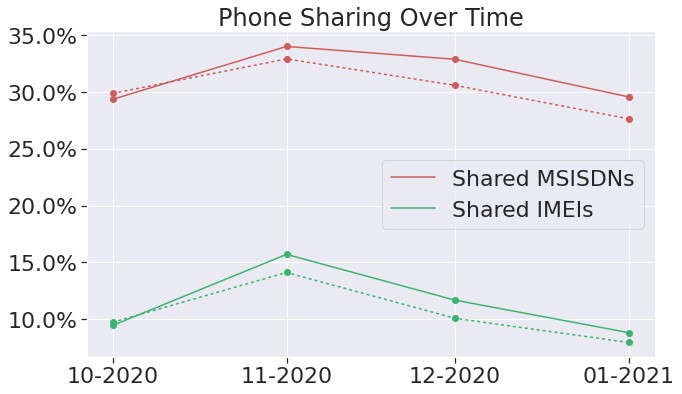

In [163]:
sns.set(font_scale=2)
timeseries = data.copy()
timeseries['month_int'] = [x[1] for x in timeseries.index]
timeseries['month_date'] = timeseries['month_int'].apply(lambda x: '2020-10' if x == 10
                                                        else '2020-11' if x == 11
                                                        else '2020-12' if x == 12
                                                        else '2021-01')
timeseries['month_date'] = pd.to_datetime(timeseries['month_date'])

fig, ax = plt.subplots(1, figsize=(10, 6))

msisdn_timeseries = timeseries[['month_date', 'imei_per_msisdn', 'treated']].dropna().copy()
avg = msisdn_timeseries.groupby(['month_date', 'treated'], as_index=False).agg('mean')
count = msisdn_timeseries.groupby(['month_date', 'treated'], as_index=False).agg('count')
treated = avg[avg['treated'] == 1]
untreated = avg[avg['treated'] == 0]
ax.plot(treated['month_date'], 100*treated['imei_per_msisdn'], label='Shared MSISDNs', 
       color='indianred')
ax.scatter(treated['month_date'], 100*treated['imei_per_msisdn'], color='indianred')
ax.plot(untreated['month_date'], 100*untreated['imei_per_msisdn'], 
        color='indianred', dashes=[2, 2])
ax.scatter(untreated['month_date'], 100*untreated['imei_per_msisdn'], color='indianred')

imei_timeseries = timeseries[['month_date', 'msisdn_per_imei', 'treated', 'imei']].dropna().copy()
avg = imei_timeseries.groupby(['month_date', 'treated'], as_index=False).agg('mean')
count = msisdn_timeseries.groupby(['month_date', 'treated'], as_index=False).agg('count')
treated = avg[avg['treated'] == 1]
untreated = avg[avg['treated'] == 0]
ax.plot(treated['month_date'], 100*treated['msisdn_per_imei'], 
        label='Shared IMEIs', color='mediumseagreen')
ax.scatter(treated['month_date'], 100*treated['msisdn_per_imei'], color='mediumseagreen')
ax.plot(untreated['month_date'], 100*untreated['msisdn_per_imei'], color='mediumseagreen', dashes=[2, 2])
ax.scatter(untreated['month_date'], 100*untreated['msisdn_per_imei'], color='mediumseagreen')


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_title('Phone Sharing Over Time')
ax.legend(loc='best')
simpleaxis(ax)
plt.tight_layout()
plt.savefig('/home/em/phoneshare.png', dpi=300)
plt.show()

In [182]:
outcome = 'imei_per_msisdn'
regressions = [
    ('Basic', ['treatmentxmonth', 'month_dummy_11', 'month_dummy_12', 'month_dummy_1']),
    ('Transactions Control', ['treatmentxmonth', 'msisdn_count_txns', 'month_dummy_11', 'month_dummy_12', 
                              'month_dummy_1']),
]

table = []
for regression, exog_vars in regressions:
    exog = sm.add_constant(data[exog_vars])
    mod = PanelOLS(data[outcome], exog, entity_effects=True, time_effects=False)
    result = mod.fit()
    
    stars = {result.pvalues.index[i]:'***' if result.pvalues[i] < 0.001 else '**' if result.pvalues[i] < 0.01 \
            else '*' if result.pvalues[i] < 0.05 else '' for i in range(len(result.pvalues))}
    params = {result.params.index[i]: ('%.4f' % result.params[i]) + stars[result.params.index[i]] \
              for i in range(len(result.params))}
    table.append({**params, **{'rsquared': '%.4f' % result.rsquared, 'n':'%i' % result.nobs}})
    
    
table = pd.DataFrame(table).T.sort_index().fillna('')
table.columns = [label for label, _ in regressions]
table = table.reindex(['const', 'treatmentxmonth', 'msisdn_count_txns', 'month_dummy_11', 'month_dummy_12', 
                       'month_dummy_1', 'rsquared', 'n'])
table

/home/em/.conda/envs/py3/lib/python3.7/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


,Basic,Transactions Control
const,0.2962***,0.2556***
treatmentxmonth,0.0305***,0.0286***
msisdn_count_txns,,0.0009***
month_dummy_11,0.0218***,0.0230***
month_dummy_12,0.0050,0.0019
month_dummy_1,-0.0254***,-0.0299***
rsquared,0.0031,0.0095
n,173654,173654


In [183]:
outcome = 'msisdn_per_imei'
regressions = [
    ('Basic', ['treatmentxmonth', 'month_dummy_11', 'month_dummy_12', 'month_dummy_1']),
    ('Transactions Control', ['treatmentxmonth', 'imei_count_txns', 'month_dummy_11', 'month_dummy_12', 
                              'month_dummy_1']),
]

table = []
for regression, exog_vars in regressions:
    exog = sm.add_constant(data[exog_vars])
    mod = PanelOLS(data[outcome], exog, entity_effects=True, time_effects=False)
    result = mod.fit()
    
    stars = {result.pvalues.index[i]:'***' if result.pvalues[i] < 0.001 else '**' if result.pvalues[i] < 0.01 \
            else '*' if result.pvalues[i] < 0.05 else '' for i in range(len(result.pvalues))}
    params = {result.params.index[i]: ('%.4f' % result.params[i]) + stars[result.params.index[i]] \
              for i in range(len(result.params))}
    table.append({**params, **{'rsquared': '%.4f' % result.rsquared, 'n':'%i' % result.nobs}})
    
    
table = pd.DataFrame(table).T.sort_index().fillna('')
table.columns = [label for label, _ in regressions]
table = table.reindex(['const', 'treatmentxmonth', 'imei_count_txns', 'month_dummy_11', 'month_dummy_12', 
                       'month_dummy_1', 'rsquared', 'n'])
table

/home/em/.conda/envs/py3/lib/python3.7/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


,Basic,Transactions Control
const,0.0975***,0.0971***
treatmentxmonth,0.0210***,0.0210***
imei_count_txns,,0.0000
month_dummy_11,0.0391***,0.0391***
month_dummy_12,0.0000,0.0001
month_dummy_1,-0.0241***,-0.0239***
rsquared,0.0106,0.0105
n,147419,147288
